In [1]:
using Revise
using Plots, CSV, DataFrames
includet("draftpolicy.jl")

┌ Info: Recompiling stale cache file /Users/evanmunro/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/evanmunro/.julia/compiled/v1.1/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1184


### I.  Example Draft Policy Plot

In [3]:
16+21+23

60

In [2]:
N=3
G= 20
s = Season(N,G)
size(s.matches)

(60, 2)

In [50]:
N= 3
G= 20 
s = Season(N,G)
abilities = zeros(N) .+ 1/N 
record,incentives = calculate_draft_rule(s,nothing,10,1,false,abilities) 

10
1
not calculating


(Record([0.333333 0.2765 … 0.000666667 0.000666667; 0.333333 0.367 … 0.349167 0.349167; 0.333333 0.3565 … 0.650167 0.650167], 45, [1 1 … 23 23; 0 0 … 18 19; 0 1 … 18 18], [0.333333 0.333333 … 0.333333 0.333333; 0.333333 0.333333 … 0.333333 0.333333; 0.333333 0.333333 … 0.333333 0.333333]), [0.0898333, 0.138833, 0.138833, 0.130833, 0.075, 0.075, 0.0883333, 0.1235, 0.1235, 0.102833  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [51]:
plot(1:length(incentives),incentives,label=[""],xlabel="Match",ylabel="Bound on Draft Probability Change")
savefig("sim3_inc.pdf")

In [52]:
plot(1:(size(record.draft_prob,2)),transpose(record.draft_prob),xlabel="Match",ylabel="Percentage",
    color=[:blue :red :green], legend=:topright,label=["T1","T2","T3"]) 
savefig("sim3_prod.pdf")

In [53]:
plot(1:(size(record.cwins,2)),transpose(record.cwins),xlabel="Match",ylabel="Wins",
    color=[:blue :red :green], legend=:top,label=["T1","T2","T3"]) 
savefig("sim3_wins.pdf")

In [257]:
plot(1:(size(record.abilities,2)),transpose(record.abilities),xlabel="Match",ylabel="Abilities",
    color=[:blue :red :green], legend=:top,label=["T1","T2","T3"]) 
#plot(1:size(record.cwins,1),record.cwins,linestyle=:dash,color=[:blue :red :green], legend=:top,
  #  title="Win Records", 
   # label=["T1","T2","T3"],xlabel="Match",ylabel="Cumulative Wins")
savefig("sim3_abilities.pdf")




#



### II. Expected Gain over Uniform Lottery

In [12]:
N=3
G=3
abilities = zeros(N).+ 1/N 
s = Season(N,G,abilities)

stops = zeros(20)
obj = zeros(20)

for m in 1:20
    o,st = expected_objective(s,m)
    obj[m] = o
    stops[m] = st 
    println("done ", m)
end 

done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
done 14
done 15
done 16
done 17
done 18
done 19
done 20


In [27]:
obj[5]

0.6689160156250007

In [ ]:
serialize("results/draft_obj.jb",obj)

In [262]:
plot(1:20,obj,color=[:blue],title="Expected Gain over Uniform Lottery",xlabel="B",ylabel="Probability",label=[""])
#savefig("sim_obj.pdf")
##plot(1:20,stops/size(s.matches,1),color=[:red],title="Games Taken Into Account",label=[""],xlabel="B",ylabel="Percent")
#savefig("sim_stops.pdf")

In [6]:
using Serialization
record = deserialize("results/run1/object1985.jb")

Record([0.0434783 0.0434636 … 0.00570767 0.00570767; 0.0434783 0.0431223 … 0.0 0.0; … ; 0.0434783 0.0431538 … 0.00336933 0.00336933; 0.0434783 0.0533649 … 0.0 0.0], 527, [0 0 … 34 34; 0 0 … 63 63; … ; 0 0 … 40 41; 0 0 … 40 40], [0.0434783 0.0434783 … 0.0434783 0.0434783; 0.0434783 0.0434783 … 0.0434783 0.0434783; … ; 0.0434783 0.0434783 … 0.0434783 0.0434783; 0.0434783 0.0434783 … 0.0434783 0.0434783])

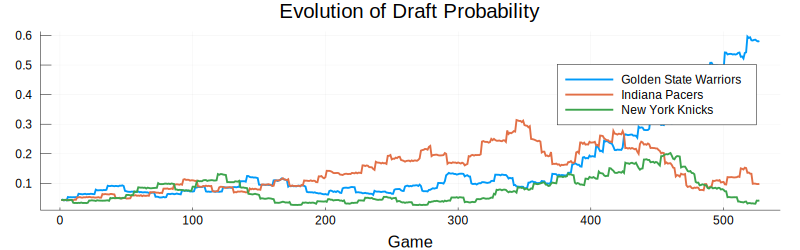

In [10]:
year = 1985
stoptime = record.stop
team_id = CSV.read(string("/Users/evanmunro/Documents/Github/draft-policy/data/cleaned/teams_",
                            string(year),".csv"))
end_wins = record.cwins[:,size(record.cwins,2)]
end_draft = record.draft_prob[:,size(record.draft_prob,2)]
df = DataFrame(id = copy(team_id[:id]),team = copy(team_id[:team]),wins = copy(end_wins),score = copy(end_draft))
sort!(df, (:wins), rev=(false))
bottom_id = df[:id][1:3]
bottom_name = df[:team][1:3]
prob = record.draft_prob[bottom_id,:]
wins = record.cwins[bottom_id,:]
plot(transpose(prob[:,1:stoptime]),label=bottom_name,
    size=(800,250),
        linewidth=4,legend=:topright,xlabel="Game",title="Evolution of Draft Probability")

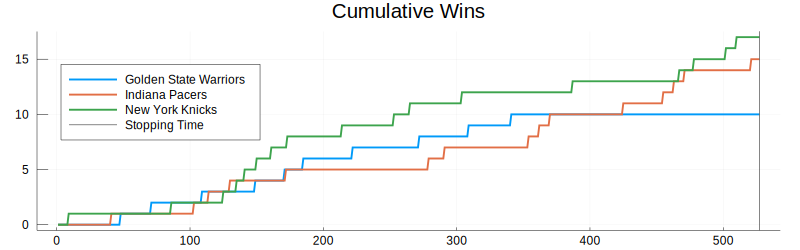

In [11]:
    plot(transpose(wins[:,1:stoptime]),label=vcat(bottom_name,["Stopping Time"]),
        size=(800,250),
        linewidth=4,legend=:topleft,title="Cumulative Wins")
    vline!([stoptime],color="black",label=vcat(bottom_name,["Stopping Time"]))

## 2. Plotting Draft Policy on Real Data

In [11]:
function simulate_season(year,mult=10)
    team_id = CSV.read(string("/Users/evanmunro/Documents/Github/draft-policy/data/cleaned/teams_",
                            string(year),".csv"))
    season = CSV.read(string("/Users/evanmunro/Documents/Github/draft-policy/data/cleaned/season_",year,".csv")) 
    matches = convert(Matrix, season[[:hID,:aID]])
    wins = convert(Array, season[:win])
    teams = convert(Array,team_id[:id])
    s = Season(teams,matches)
    record,_=calculate_draft_rule(s,wins,mult,16)
    stoptime=record.stop
    println(record.stop)
    end_wins = record.cwins[:,size(record.cwins,2)]
    end_draft = record.draft_prob[:,size(record.draft_prob,2)] 

    df = DataFrame(team = copy(team_id[:team]),wins = copy(end_wins),score = copy(end_draft))
    sort!(df, (:wins), rev=(true))

    added_amt = sum(df[1:16,:score])/(length(teams)-16)
    df[17:length(teams),:score] = df[17:length(teams),:score] .+ added_amt 
    df[1:16,:score] =  0 
    df[17:length(teams),:]
end

simulate_season (generic function with 2 methods)

In [16]:
year = 2015 
simulate_season(year)

10
16
not calculating
332


,team,wins,score
,String⍰,Int64,Float64
1,Phoenix Suns,39,0.0048869
2,Brooklyn Nets,38,0.0104702
3,Indiana Pacers,38,0.0416369
4,Utah Jazz,38,0.0750536
5,Miami Heat,37,0.0081369
6,Charlotte Hornets,33,0.0450536
7,Detroit Pistons,32,0.209554
8,Denver Nuggets,30,0.0046369
9,Sacramento Kings,29,0.00722024


In [2]:
#1985,1987,1988,1989
year = 1985 
team_id = CSV.read(string("/Users/evanmunro/Documents/Github/draft-policy/data/cleaned/teams_",
                            string(year),".csv"))
season = CSV.read(string("/Users/evanmunro/Documents/Github/draft-policy/data/cleaned/season_",year,".csv")) 
team_id

,team,id
,String⍰,Int64⍰
1,Atlanta Hawks,1
2,Boston Celtics,2
3,Chicago Bulls,3
4,Cleveland Cavaliers,4
5,Dallas Mavericks,5
6,Denver Nuggets,6
7,Detroit Pistons,7
8,Golden State Warriors,8
9,Houston Rockets,9


In [5]:
sort!(team_id,:id,rev=true)

,team,id
,String⍰,Int64⍰
1,Washington Bullets,23
2,Utah Jazz,22
3,Seattle SuperSonics,21
4,San Antonio Spurs,20
5,Portland Trail Blazers,19
6,Phoenix Suns,18
7,Philadelphia 76ers,17
8,New York Knicks,16
9,New Jersey Nets,15


In [16]:
function simulate_season(year,mult=10)
    team_id = CSV.read(string("/Users/evanmunro/Documents/Github/draft-policy/data/cleaned/teams_",
                            string(year),".csv"))
    season = CSV.read(string("/Users/evanmunro/Documents/Github/draft-policy/data/cleaned/season_",year,".csv"))
    matches = convert(Matrix, season[[:hID,:aID]])
    wins = convert(Array, season[:win])
    teams = convert(Array,team_id[:id])
    s = Season(teams,matches)
    record,_=calculate_draft_rule(s,wins,mult,16)
    stoptime=record.stop
    end_wins = record.cwins[:,size(record.cwins,2)]
    end_draft = record.draft_prob[:,size(record.draft_prob,2)]
    print("got here")
    df = DataFrame(id = copy(team_id[:id]),team = copy(team_id[:team]),wins = copy(end_wins),score = copy(end_draft))
    sort!(df, (:wins), rev=(false))
    bottom_id = df[:id][1:3]
    bottom_name = df[:team][1:3]
    prob = record.draft_prob[bottom_id,:]
    wins = record.cwins[bottom_id,:]
    plot(transpose(prob[:,1:stoptime]),label=bottom_name,
        size=(800,250),
        linewidth=4,legend=:topright,xlabel="Game",title="Evolution of Draft Probability")
    savefig(string("prob",string(year),".pdf"))

    plot(transpose(wins[:,1:stoptime]),label=vcat(bottom_name,["Stopping Time"]),
        size=(800,250),
        linewidth=4,legend=:topleft,title="Cumulative Wins")
    vline!([stoptime],color="black",label=vcat(bottom_name,["Stopping Time"]))
    savefig(string("wins",string(year),".pdf"))

    CSV.write(string("record",string(year),".csv"),df)
    df 
end

simulate_season (generic function with 2 methods)

In [17]:
simulate_season(1986)

10
16
not calculating
got here

,id,team,wins,score
,Int64⍰,String⍰,Int64,Float64
1,15,New York Knicks,23,0.0333333
2,10,Indiana Pacers,26,0.03
3,4,Cleveland Cavaliers,29,0.015
4,3,Chicago Bulls,30,0.0475
5,8,Golden State Warriors,30,0.05
6,21,Seattle SuperSonics,31,0.0795
7,11,Los Angeles Clippers,32,0.0566667
8,17,Phoenix Suns,32,0.0125
9,20,San Antonio Spurs,35,0.025


In [119]:
matches = convert(Matrix, season[[:hID,:aID]])
wins = convert(Array, season[:win])
teams = convert(Array,team_id[:id])
s = Season(teams,matches)
#0.5 had good results 
#wins
record=calculate_draft_rule(s,wins,1.05,16)
stoptime=record.stop
println(record.stop)
end_wins = record.cwins[:,size(record.cwins,2)]
end_draft = record.draft_prob[:,size(record.draft_prob,2)] 

df = DataFrame(team = copy(team_id[:team]),wins = copy(end_wins),score = copy(end_draft))
sort!(df, (:wins), rev=(true))

added_amt = sum(df[1:16,:score])/(length(teams)-16)
df[17:length(teams),:score] = df[17:length(teams),:score] .+ added_amt 
df[1:16,:score] =  0 
df[17:length(teams),:]
# reduce at 69 when multiple=5

1.05
16
97


,team,wins,score
,String⍰,Int64,Float64
1,Atlanta Hawks,34,0.131667
2,Kansas City Kings,31,0.15875
3,Los Angeles Clippers,31,0.111583
4,Seattle SuperSonics,31,0.136583
5,New York Knicks,24,0.1435
6,Golden State Warriors,22,0.12825
7,Indiana Pacers,22,0.189667


In [126]:
bottom3 = [16,8,10]
prob = record.draft_prob[bottom3,:]
wins = record.cwins[bottom3,:]
plot(transpose(prob[:,1:250]).+added_amt,label=["Knicks","Warriors","Spurs"],
    size=(800,250),
    #ylims=(0.05,0.3),
    linewidth=4,legend=:topright,xlabel="Game",title="Evolution of Draft Probability")
savefig("prob85.pdf")

In [121]:
plot(transpose(wins[:,1:250]),label=["Knicks","Warriors","Spurs","Stopping Time"],
    size=(800,250),
    linewidth=4,legend=:topleft,title="Cumulative Wins")
vline!([stoptime],color="black",label=["Knicks","Warriors","Spurs","Stopping Time"])
savefig("wins85.pdf")

In [94]:
year = 1989
team_id = CSV.read(string("/Users/evanmunro/Documents/Github/draft-policy/data/cleaned/teams_",
                            string(year),".csv"))
season = CSV.read(string("/Users/evanmunro/Documents/Github/draft-policy/data/cleaned/season_",year,".csv")) 
team_id

,team,id
,String⍰,Int64⍰
1,Atlanta Hawks,1
2,Boston Celtics,2
3,Charlotte Hornets,3
4,Chicago Bulls,4
5,Cleveland Cavaliers,5
6,Dallas Mavericks,6
7,Denver Nuggets,7
8,Detroit Pistons,8
9,Golden State Warriors,9


In [99]:
matches = convert(Matrix, season[[:hID,:aID]])
wins = convert(Array, season[:win])
teams = convert(Array,team_id[:id])
s = Season(teams,matches)
#0.5 had good results 
#wins
record=calculate_draft_rule(s,wins,15,16)
println(record.stop)
end_wins = record.cwins[:,size(record.cwins,2)]
end_draft = record.draft_prob[:,size(record.draft_prob,2)] 
df = DataFrame(team = copy(team_id[:team]),wins = copy(end_wins),score = copy(end_draft))
sort!(df, (:wins), rev=(true))

added_amt = sum(df[1:16,:score])/(length(teams)-16)
df[17:length(teams),:score] = df[17:length(teams),:score] .+ added_amt 
df[1:16,:score] =  0 
df[17:length(teams),:]

15
16
333


,team,wins,score
,String⍰,Int64,Float64
1,Portland Trail Blazers,39,0.00868519
2,Dallas Mavericks,38,0.00868519
3,Indiana Pacers,28,0.216352
4,Sacramento Kings,27,0.118019
5,New Jersey Nets,26,0.0136852
6,Los Angeles Clippers,21,0.0323519
7,San Antonio Spurs,21,0.0883519
8,Charlotte Hornets,20,0.0788519
9,Miami Heat,15,0.435019


In [104]:
bottom3 = [14,3,22]
prob = record.draft_prob[bottom3,:]
wins = record.cwins[bottom3,:]
plot(transpose(prob[:,1:500]).+added_amt,label=["Heat","Hornets","Spurs"],
    size=(800,250), linewidth=4,
    legend=:topleft,xlabel="Game",title="Evolution of Draft Probability")
savefig("prob89.pdf")

In [105]:
plot(transpose(wins[:,1:500]),label=["Heat","Hornets","Spurs","Stopping Time"],
    linewidth=4,size=(800,250),
    legend=:topleft,title="Cumulative Wins")
vline!([333],color="black",label=["Heat","Hornets","Spurs","Stopping Time"])
savefig("wins89.pdf")

In [4]:
year = 1987
team_id = CSV.read(string("/Users/evanmunro/Documents/Github/draft-policy/data/cleaned/teams_",
                            string(year),".csv"))
season = CSV.read(string("/Users/evanmunro/Documents/Github/draft-policy/data/cleaned/season_",year,".csv")) 
team_id

,team,id
,String⍰,Int64⍰
1,Atlanta Hawks,1
2,Boston Celtics,2
3,Chicago Bulls,3
4,Cleveland Cavaliers,4
5,Dallas Mavericks,5
6,Denver Nuggets,6
7,Detroit Pistons,7
8,Golden State Warriors,8
9,Houston Rockets,9


In [11]:
matches = convert(Matrix, season[[:hID,:aID]])
wins = convert(Array, season[:win])
teams = convert(Array,team_id[:id])
s = Season(teams,matches)
#0.5 had good results 
#wins
record=calculate_draft_rule(s,wins,5,16)
println(record.stop)
end_wins = record.cwins[:,size(record.cwins,2)]
end_draft = record.draft_prob[:,size(record.draft_prob,2)] 
df = DataFrame(team = copy(team_id[:team]),wins = copy(end_wins),score = copy(end_draft))
sort!(df, (:wins), rev=(true))

added_amt = sum(df[1:16,:score])/(length(teams)-16)
df[17:length(teams),:score] = df[17:length(teams),:score] .+ added_amt 
df[1:16,:score] =  0 
df[17:length(teams),:]

5
16
350


,team,wins,score
,String⍰,Int64,Float64
1,Phoenix Suns,36,0.0118929
2,Cleveland Cavaliers,31,0.0142262
3,Sacramento Kings,29,0.11176
4,San Antonio Spurs,28,0.170343
5,New Jersey Nets,24,0.0947595
6,New York Knicks,24,0.0893429
7,Los Angeles Clippers,12,0.507676


In [ ]:
bottom3 = [14,3,22]
prob = record.draft_prob[bottom3,:]
wins = record.cwins[bottom3,:]
plot(transpose(prob[:,1:500]).+added_amt,label=["Heat","Hornets","Spurs"],
    size=(800,250), linewidth=4,
    legend=:topleft,xlabel="Game",title="Evolution of Draft Probability")
savefig("prob87.pdf")

In [ ]:
plot(transpose(wins[:,1:500]),label=["Heat","Hornets","Spurs","Stopping Time"],
    linewidth=4,size=(800,250),
    legend=:topleft,title="Cumulative Wins")
vline!([333],color="black",label=["Heat","Hornets","Spurs","Stopping Time"])
savefig("wins87.pdf")